In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Streak"

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as tik

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:45.0) Gecko/20100101 Firefox/45.0'}
pd.set_option('display.max_rows', None) 
path="/content/drive/My Drive/FreePicks/"
path_res="/content/drive/My Drive/Results/"
www='https://contests.covers.com'

cappers=['AAA_Sports','Al_McMordie','American_Sports_Analysts','Ben_Burns','Chris_Elliott','Dan_Kaiser','Forum_Legends', 'Jesse_Schule','Larry_Ness','Marc_Lawrence',
 'Matt_Fargo','Mike_Lundin','Power_Sports','Ricky_Tran','Scott_Rickenbach','Spread_Knowledge','Teddy_Covers','Tim_Michael', 'Will_Rogers']

In [3]:
r=requests.get('https://experts.covers.com/freepicks',headers=headers)
soup=BeautifulSoup(r.text,'html.parser')
picks=soup.find_all(class_='col-xs-12 coversExperts-FreePicksBorder')
cols=['League','Matchup','Capper','Pick','WL']
dat=(dt.now()).strftime('%y-%m-%d')
FP=pd.DataFrame(columns=[x for x in range(5)])
for el in range(len(picks)):
  team2=picks[el].find(class_='coversExperts-FreePickModal-LeftTeamContainer').find(class_='logo').get('data-participant')
  team1=picks[el].find(class_='coversExperts-FreePickModal-RightTeamContainer').find(class_='logo').get('data-participant')
  teams=team2+' at '+team1
  teams=picks[el].find(class_='coversExpertsFreePicksDetails-CompetitionTitle').get_text().replace('vs.','at')
  capper=picks[el].find('a').get_text().replace(' ','_')
  sport=picks[el].find(class_='covers-fontW-600').get_text()
  if sport in ['NBA','NHL','NFL','MLB','NCAAB','NCAAF']:
    pick=picks[el].find('td').get_text()
    x=pick.find('(')
    pick=pick[:x-1]
    #print(sport,teams,capper,pick)
    temp=(pd.DataFrame(pd.Series([sport,teams,capper,pick,''])).T)
    FP=FP.append(temp)
FP.columns=cols
FP=FP.reset_index(drop=True)
FP=FP.sort_values(['League'])
display(FP[FP['League']=='MLB'],FP)
FP.to_csv(path+'FP_{}.csv'.format(dat),index=False)

,League,Matchup,Capper,Pick,WL
0,MLB,Tampa Bay at NY Yankees,Ben_Burns,NYY,
1,MLB,Miami at Atlanta,Will_Rogers,Under 8.5,
2,MLB,Tampa Bay at NY Yankees,AAA_Sports,Under 9,
3,MLB,Oakland at Houston,Larry_Ness,OAK,
4,MLB,Miami at Atlanta,Mike_Lundin,-1.5 ATL,


,League,Matchup,Capper,Pick,WL
0,MLB,Tampa Bay at NY Yankees,Ben_Burns,NYY,
1,MLB,Miami at Atlanta,Will_Rogers,Under 8.5,
2,MLB,Tampa Bay at NY Yankees,AAA_Sports,Under 9,
3,MLB,Oakland at Houston,Larry_Ness,OAK,
4,MLB,Miami at Atlanta,Mike_Lundin,-1.5 ATL,


In [ ]:
picks[0].find('a').get_text()

'Jesse Schule'

**РЕЗУЛЬТАТЫ**

In [ ]:
#СБОР ВСЕХ РЕЗОВ В ОБЩИЙ ФАЙЛ И ЗА 1 ДЕНЬ
def del_sk(vval):
  if vval[-5]=='(':
    return vval[:-6]
  else:
    return vval[:-7]
def WinLose(row):
  ret='-'
  if 'Over' in row['Pick']:
    if row['Total']=='O':
      ret='W'
    elif row['Total']=='U':
      ret='L'
    else:
      ret='P'
  elif 'Under' in row['Pick']:
    if row['Total']=='U':
      ret='W'
    elif row['Total']=='O':
      ret='L'
    else:
      ret='P'
  elif str(row['Winner']) in str(row['Pick']):
    ret='W'
  elif row['Winner']=='Push':
    ret='P'
  else:
    ret='L'
  return ret

def correct(row): #меняем название, перекидываем команды
  cap=row['Capper'].replace('_',' ').title().replace(' ','_').replace('Aaa','AAA').replace('Mcmordie','McMordie')
  row['Capper']=cap
  if row['Pick']=='CHW':
    row['Matchup']=row['Matchup'].replace('Chicago', 'Chi. White Sox')
  if row['Pick']=='CHC':
    row['Matchup']=row['Matchup'].replace('Chicago', 'Chi. Cubs')
  if 'Oakland' in row['Matchup'] and row['League']=='NFL':
    row['Matchup']=row['Matchup'].replace('Oakland','Las Vegas')
  t2=row['Matchup'].split(' at ')[0]
  t1=row['Matchup'].split(' at ')[1]
  new_liga=results.query(f"League=='{row['League']}'")  #исключаем одноименные команды из других лиг
  new_matchup=''
  if t1 in ['Los Angeles','New York','LA Lakers','LA Clippers','L.A.']:
    new_matchup=list(map(lambda x: x if t2 in x else '',list(new_liga['Matchup'])))
  new_matchup=''.join(new_matchup)
  if new_matchup!='':
    row['Matchup']=new_matchup
  new_matchup=''
  if t2 in ['Los Angeles','New York','LA Lakers','LA Clippers','L.A.']:
    new_matchup=list(map(lambda x: x if t1 in x else '',list(new_liga['Matchup'])))
  new_matchup=''.join(new_matchup)
  if new_matchup!='':
    row['Matchup']=new_matchup

  if t1+' at '+t2 in list(results['Matchup']):
    row['Matchup']=t1+' at '+t2
  return row
def dropNext(row):  #убираем не сыгравшие пока команды
  if row['Total']=='-':
    row['WL']=float('nan')
  return row

files=os.listdir(path)
files=sorted(files)[:-1]
for f in files[-1:]:
  date_res=f[3:-4]
  date_picks=f[3:-4]
  picks=pd.read_csv(path+'FP_{}.csv'.format(date_picks))
  results=pd.read_csv(path_res+'{}.csv'.format(date_res))
  nfl_picks=picks.query("League=='NFL'")
  nfl_picks.reset_index(drop=True,inplace=True)
  nfl_res=results.query("League=='NFL'")
  nfl_picks=nfl_picks.apply(correct,axis=1)
  picks=picks.apply(correct,axis=1)
  for i in range(len(nfl_picks)):
    if 'New York' in nfl_picks.loc[i,'Matchup']:
      team=nfl_picks.loc[i,'Matchup'].replace('New York','')
      for el in nfl_res['Matchup'].to_list():
        if team in el:
          nfl_picks.loc[i,'Matchup']=el
          break
  picks=picks.query("League!='NFL' & League!='CFL'")
  picks=picks.append(nfl_picks,sort=False)

  #picks['Matchup']=picks.Matchup.apply(lambda x: x.replace(' at. ',' at '))
  #picks['Pick']=picks.Pick.apply(del_sk)
  picks=picks.merge(results,how='left',on=['League','Matchup']).drop(labels=['Teams','Date'],axis=1)
  picks.insert(0,'Date',date_res)
  wl=picks.apply(WinLose,axis=1)
  picks['WL']=wl
  picks=picks.apply(dropNext,axis=1)
  picks=picks.dropna()
  display(picks.sort_values(['League']))
  save=input('Записать?')
  if save in ['y','н']:
    picks.to_csv(path+'FreePicks_All.csv',index=False,mode='a',header=False)
    display(f)

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
0,20-10-06,MLB,NY Yankees at Tampa Bay,Spread_Knowledge,NYY,L,O,TB
1,20-10-06,MLB,San Diego at LA Dodgers,Scott_Rickenbach,LAD,W,U,LAD
2,20-10-06,MLB,NY Yankees at Tampa Bay,AAA_Sports,Over 8,W,O,TB
3,20-10-06,MLB,San Diego at LA Dodgers,Ben_Burns,LAD,W,U,LAD
4,20-10-06,MLB,San Diego at LA Dodgers,Power_Sports,LAD,W,U,LAD
5,20-10-06,MLB,NY Yankees at Tampa Bay,Will_Rogers,TB,W,O,TB
6,20-10-06,MLB,Houston at Oakland,Mike_Lundin,HOU,W,U,HOU
7,20-10-06,MLB,San Diego at LA Dodgers,American_Sports_Analysts,-1.5 LAD,W,U,LAD
8,20-10-06,MLB,Houston at Oakland,Matt_Fargo,OAK,L,U,HOU


Записать?н


'FP_20-10-06.csv'

In [ ]:
pd.read_csv(path_res+'{}.csv'.format(date_res))

,Date,League,Matchup,Teams,Total,Winner
0,20-09-29,MLB,Houston at MinnesotaWild Card Showdown,HOU at. MIN,U,HOU
1,20-09-29,MLB,Chi. White Sox at OaklandWild Card Showdown,CHW at. OAK,U,CHW
2,20-09-29,MLB,Toronto at Tampa BayWild Card Showdown,TOR at. TB,U,TB
3,20-09-29,MLB,NY Yankees at ClevelandWild Card Showdown,NYY at. CLE,O,NYY


In [ ]:
all_fp=pd.read_csv(path+'FreePicks_All.csv')
df_cappers=pd.DataFrame()
for el in cappers:
  cap=all_fp.query(f"Capper=='{el}'")
  stat=cap['WL'].value_counts().to_list()
  if len(stat)>1:
    proc=int(stat[0]/(stat[0]+stat[1])*100)
  else:
    proc=0
  tmp=pd.Series([el,cap['WL'].value_counts().index[0],proc,stat])
  df_cappers=df_cappers.append(pd.DataFrame(tmp).T)
df_cappers.columns=['Capper','WL','Proc','Stat']
display(df_cappers.sort_values(by=['WL','Proc'],ascending=False))

,Capper,WL,Proc,Stat
0,Ben_Burns,W,73,"[34, 12, 3]"
0,American_Sports_Analysts,W,71,"[15, 6, 1]"
0,Will_Rogers,W,64,"[20, 11]"
0,Mike_Lundin,W,63,"[46, 27, 1]"
0,Dan_Kaiser,W,62,"[17, 10, 1]"
0,Ricky_Tran,W,57,"[16, 12]"
0,AAA_Sports,W,56,"[34, 26, 2]"
0,Matt_Fargo,W,55,"[5, 4]"
0,Jesse_Schule,W,51,"[16, 15, 2]"
0,Power_Sports,W,50,"[30, 30, 3]"


In [ ]:
el

'Anthony Stalter'

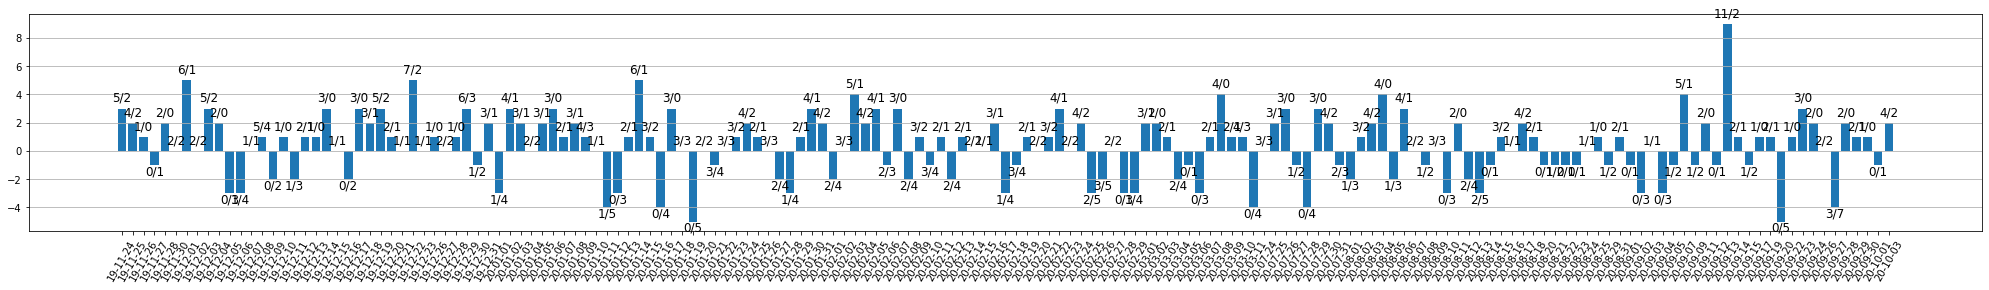

In [ ]:
sum_date=all_fp.groupby(by=['Date'])['WL'].value_counts()
sum_date=pd.DataFrame(sum_date)
#sum_date.loc['19-11-24']['WL']['L']
date_list=all_fp['Date'].unique()
days_stat=pd.DataFrame()
for el in date_list:
  if 'W' not in sum_date.loc[el]['WL'].index:
    w=0
  else:
    w=sum_date.loc[el]['WL']['W']
  if 'L' not in sum_date.loc[el]['WL'].index:
    l=0
  else:
    l=sum_date.loc[el]['WL']['L']
  tmp=[el,w,l,w-l]
  tmp=pd.DataFrame(pd.Series(tmp)).T
  days_stat=days_stat.append(tmp)
days_stat.columns=['Date','W','L','Dif']
days_stat.reset_index(inplace=True)
days_stat.tail()
plt.figure(figsize=(35,4))
plt.bar(days_stat['Date'],days_stat['Dif'])
plt.xticks(rotation=60)
plt.grid(axis='y')
for i in range(len(days_stat)):
  if days_stat.loc[i,'Dif']>=0:
    plt.text(i,days_stat.loc[i,'Dif']+0.5,f"{days_stat.loc[i,'W']}/{days_stat.loc[i,'L']}",fontsize=12,ha='center')
  else:
    plt.text(i,days_stat.loc[i,'Dif']-0.7,f"{days_stat.loc[i,'W']}/{days_stat.loc[i,'L']}",fontsize=12,ha='center')
plt.show()

In [ ]:
all_fp['WL'].value_counts()

W    293
L    240
P     17
Name: WL, dtype: int64

,Capper,WL,Proc,Stat,League,Matchup,Pick
2,American_Sports_Analysts,W,71,"[15, 6, 1]",NFL,Arizona at Carolina,-2.5 ARI
3,Ben_Burns,W,73,"[34, 12, 3]",NFL,Minnesota at Houston,Under 54
5,Dan_Kaiser,W,62,"[17, 10, 1]",NFL,Indianapolis at Chicago,Under 43
8,Larry_Ness,L,54,"[28, 23, 1]",NFL,Baltimore at Washington,-14 BAL
9,Marc_Lawrence,L,61,"[35, 22, 3]",NFL,Buffalo at Las Vegas,3.5 LV
10,Matt_Fargo,W,55,"[5, 4]",NFL,Seattle at Miami,6.5 MIA
11,Mike_Lundin,W,63,"[46, 27, 1]",NFL,L.A. Chargers at Tampa Bay,7 LAC
12,Power_Sports,W,50,"[30, 30, 3]",NFL,Indianapolis at Chicago,-3 IND
14,Scott_Rickenbach,L,56,"[13, 10]",NFL,N.Y. Giants at L.A. Rams,13.5 NYG
16,Teddy_Covers,L,50,"[29, 28, 1]",NFL,Indianapolis at Chicago,-2.5 IND



 American_Sports_Analysts 


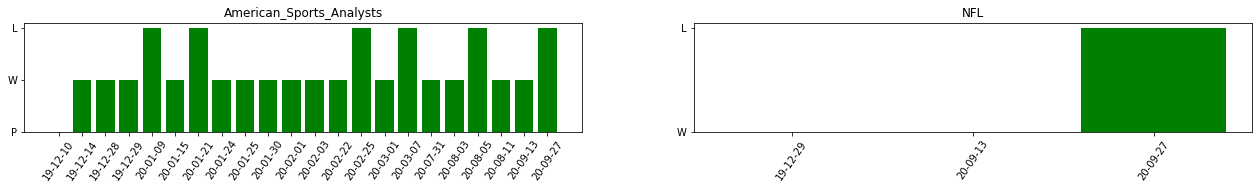

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
522,20-08-03,NHL,Washington at Tampa Bay,American_Sports_Analysts,TB,W,U,TB
531,20-08-05,NHL,Pittsburgh at Montreal,American_Sports_Analysts,PIT,L,O,MON
554,20-08-11,NHL,Columbus at Tampa Bay,American_Sports_Analysts,TB,W,U,TB
627,20-09-13,NFL,Arizona at San Francisco,American_Sports_Analysts,7 ARI,W,U,ARI
669,20-09-27,NFL,Houston at Pittsburgh,American_Sports_Analysts,4 HOU,L,O,PIT


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
129,19-12-29,NFL,Cleveland at Cincinnati,American_Sports_Analysts,3 CIN,W,O,CIN
627,20-09-13,NFL,Arizona at San Francisco,American_Sports_Analysts,7 ARI,W,U,ARI
669,20-09-27,NFL,Houston at Pittsburgh,American_Sports_Analysts,4 HOU,L,O,PIT



 Ben_Burns 


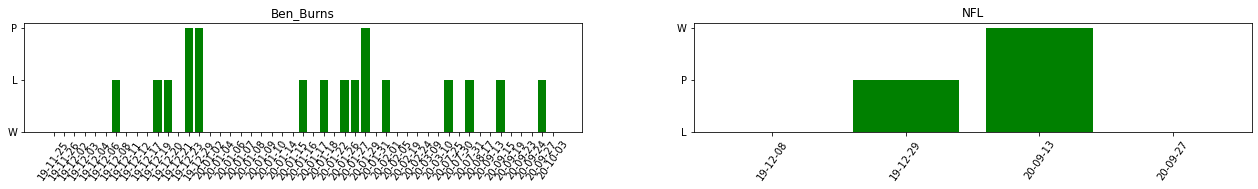

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
645,20-09-19,MLB,Kansas City at Milwaukee,Ben_Burns,Under 8.5,W,U,MIL
656,20-09-23,NHL,Tampa Bay at Dallas,Ben_Burns,TB,W,O,TB
660,20-09-24,NCAAF,UAB at South Alabama,Ben_Burns,Over 45,W,O,UAB
667,20-09-27,NFL,Dallas at Seattle,Ben_Burns,5 DAL,L,O,SEA
684,20-10-03,NCAAF,Texas A&M at Alabama,Ben_Burns,-17 ALA,W,O,ALA


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
53,19-12-08,NFL,Pittsburgh at Arizona,Ben_Burns,2.5 ARI,L,U,PIT
123,19-12-29,NFL,Arizona at L.A. Rams,Ben_Burns,7.5 ARI,P,O,Push
634,20-09-13,NFL,Las Vegas at Carolina,Ben_Burns,0 LV,W,O,LV
667,20-09-27,NFL,Dallas at Seattle,Ben_Burns,5 DAL,L,O,SEA



 Dan_Kaiser 


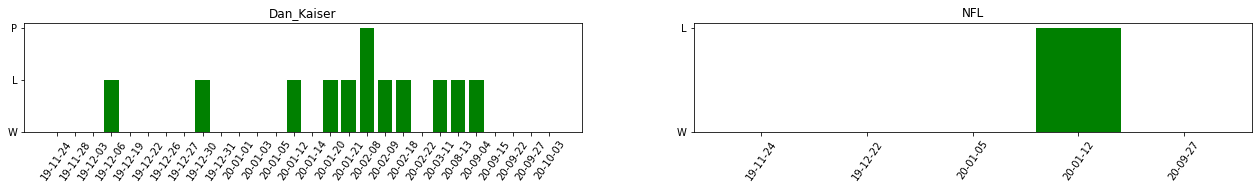

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
607,20-09-04,MLB,Miami at Tampa Bay,Dan_Kaiser,Under 8,L,O,TB
643,20-09-15,NBA,Denver at L.A. Clippers,Dan_Kaiser,Under 207.5,W,U,DEN
653,20-09-22,NBA,L.A. Lakers at Denver,Dan_Kaiser,Over 213.5,W,O,DEN
666,20-09-27,NFL,Chicago at Atlanta,Dan_Kaiser,Over 47,W,O,CHI
682,20-10-03,NCAAF,North Carolina at Boston College,Dan_Kaiser,Under 54.5,W,U,BC


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
1,19-11-24,NFL,N.Y. Giants at Chicago,Dan_Kaiser,Under 40.5,W,U,NYG
108,19-12-22,NFL,Pittsburgh at N.Y. Jets,Dan_Kaiser,Under 37,W,U,NYJ
158,20-01-05,NFL,Seattle at Philadelphia,Dan_Kaiser,Under 45,W,U,SEA
187,20-01-12,NFL,Seattle at Green Bay,Dan_Kaiser,Under 45.5,L,O,GB
666,20-09-27,NFL,Chicago at Atlanta,Dan_Kaiser,Over 47,W,O,CHI



 Larry_Ness 


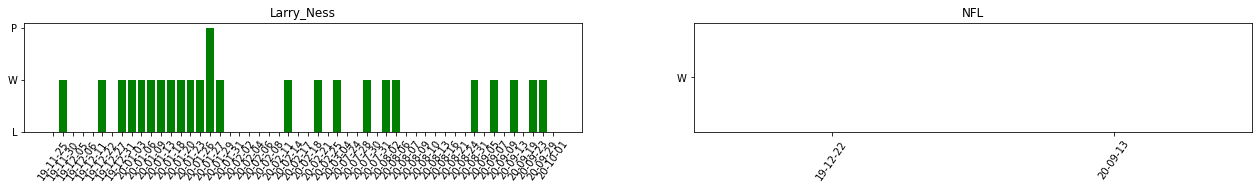

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
636,20-09-13,NFL,Chicago at Detroit,Larry_Ness,3 CHI,W,O,CHI
646,20-09-19,MLB,Texas at LA Angels,Larry_Ness,TEX,L,U,LAA
654,20-09-23,MLB,Milwaukee at Cincinnati,Larry_Ness,CIN,W,U,CIN
678,20-09-29,MLB,NY Yankees at Cleveland,Larry_Ness,NYY,W,O,NYY
681,20-10-01,MLB,Milwaukee at LA Dodgers,Larry_Ness,MIL,L,U,LAD


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
103,19-12-22,NFL,Jacksonville at Atlanta,Larry_Ness,-7 ATL,W,U,ATL
636,20-09-13,NFL,Chicago at Detroit,Larry_Ness,3 CHI,W,O,CHI



 Marc_Lawrence 


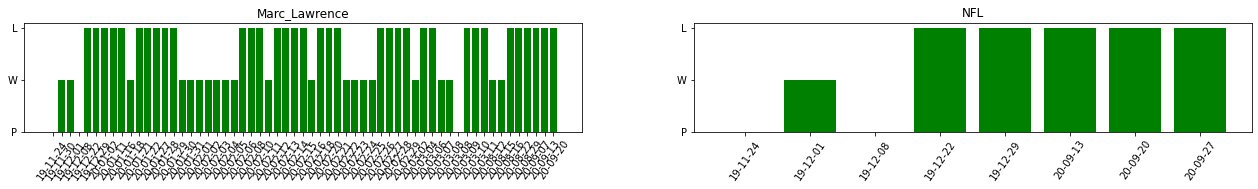

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
594,20-08-29,MLB,Tampa Bay at Miami,Marc_Lawrence,MIA,L,U,TB
613,20-09-07,MLB,Arizona at San Francisco,Marc_Lawrence,ARI,L,U,SF
631,20-09-13,NFL,Las Vegas at Carolina,Marc_Lawrence,3 CAR,L,O,LV
651,20-09-20,NFL,San Francisco at N.Y. Jets,Marc_Lawrence,7 NYJ,L,O,SF
674,20-09-27,NFL,Tennessee at Minnesota,Marc_Lawrence,-3 TEN,L,O,MIN


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
109,19-12-22,NFL,Cincinnati at Miami,Marc_Lawrence,0 CIN,L,O,MIA
128,19-12-29,NFL,Atlanta at Tampa Bay,Marc_Lawrence,0 TB,L,O,ATL
631,20-09-13,NFL,Las Vegas at Carolina,Marc_Lawrence,3 CAR,L,O,LV
651,20-09-20,NFL,San Francisco at N.Y. Jets,Marc_Lawrence,7 NYJ,L,O,SF
674,20-09-27,NFL,Tennessee at Minnesota,Marc_Lawrence,-3 TEN,L,O,MIN



 Matt_Fargo 


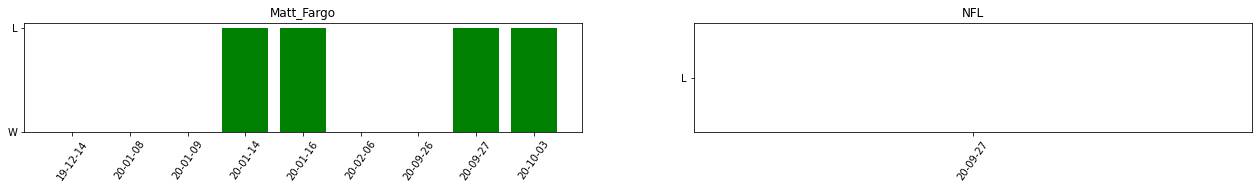

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
204,20-01-16,NCAAB,North Texas at Southern Miss,Matt_Fargo,6.5 USM,L,U,UNT
317,20-02-06,NCAAB,James Madison at Drexel,Matt_Fargo,-6 DREX,W,U,DREX
663,20-09-26,NCAAF,Georgia Tech at Syracuse,Matt_Fargo,8 SYR,W,O,SYR
672,20-09-27,NFL,Dallas at Seattle,Matt_Fargo,5 DAL,L,O,SEA
685,20-10-03,NCAAF,Oklahoma at Iowa State,Matt_Fargo,-7 OKLA,L,O,ISU


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
672,20-09-27,NFL,Dallas at Seattle,Matt_Fargo,5 DAL,L,O,SEA



 Mike_Lundin 


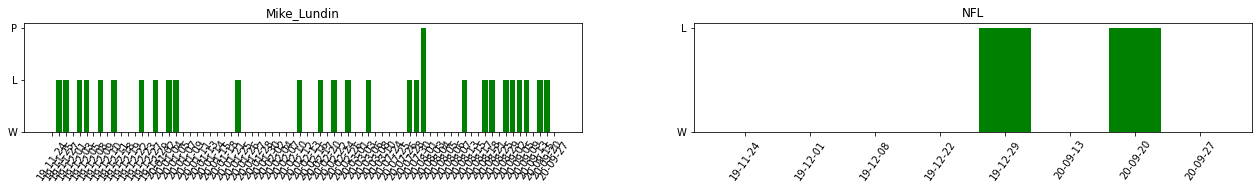

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
620,20-09-09,MLB,Chi. White Sox at Pittsburgh,Mike_Lundin,1.5 PIT,L,P,CHW
637,20-09-13,NFL,Seattle at Atlanta,Mike_Lundin,Over 49,W,O,SEA
642,20-09-15,MLB,St. Louis at Milwaukee,Mike_Lundin,STL,L,O,MIL
652,20-09-20,NFL,Carolina at Tampa Bay,Mike_Lundin,9.5 CAR,L,O,TB
668,20-09-27,NFL,Tennessee at Minnesota,Mike_Lundin,2.5 MIN,W,O,MIN


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
110,19-12-22,NFL,Pittsburgh at N.Y. Jets,Mike_Lundin,Under 37,W,U,NYJ
127,19-12-29,NFL,Las Vegas at Denver,Mike_Lundin,-3 DEN,L,U,LV
637,20-09-13,NFL,Seattle at Atlanta,Mike_Lundin,Over 49,W,O,SEA
652,20-09-20,NFL,Carolina at Tampa Bay,Mike_Lundin,9.5 CAR,L,O,TB
668,20-09-27,NFL,Tennessee at Minnesota,Mike_Lundin,2.5 MIN,W,O,MIN



 Power_Sports 


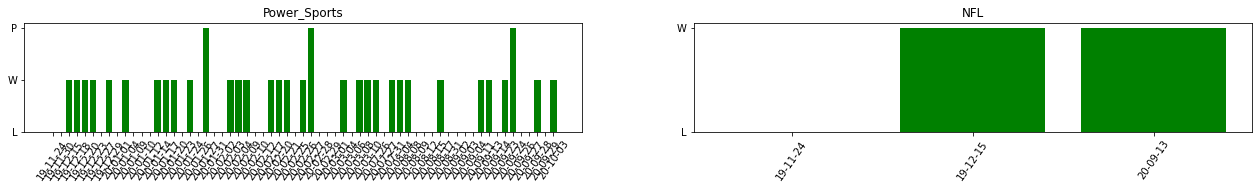

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
664,20-09-26,NHL,Dallas at Tampa Bay,Power_Sports,TB,L,P,DAL
665,20-09-27,NBA,Boston at Miami,Power_Sports,-3 BOS,L,O,MIA
676,20-09-28,NHL,Tampa Bay at Dallas,Power_Sports,TB,W,U,TB
679,20-09-29,MLB,NY Yankees at Cleveland,Power_Sports,Under 6.5,L,O,NYY
687,20-10-03,NCAAF,Texas Tech at Kansas State,Power_Sports,-2.5 KSU,W,U,KSU


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
6,19-11-24,NFL,Denver at Buffalo,Power_Sports,4 DEN,L,U,BUF
79,19-12-15,NFL,Cleveland at Arizona,Power_Sports,3 ARI,W,O,ARI
635,20-09-13,NFL,L.A. Chargers at Cincinnati,Power_Sports,LAC,W,P,LAC



 Scott_Rickenbach 


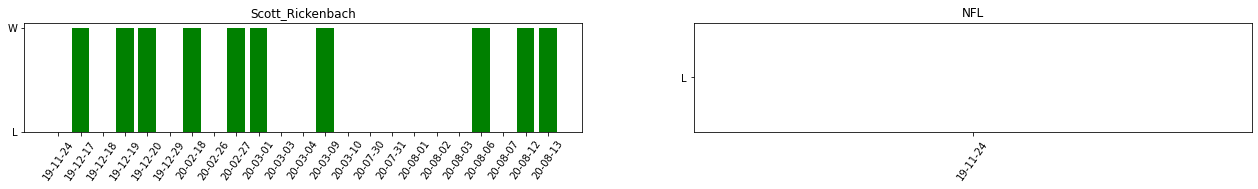

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
517,20-08-03,MLB,Philadelphia at NY Yankees,Scott_Rickenbach,PHI,L,P,NYY
536,20-08-06,NHL,Vancouver at Minnesota,Scott_Rickenbach,Under 5.5,W,U,VAN
540,20-08-07,NHL,Toronto at Columbus,Scott_Rickenbach,CLB,L,O,TOR
559,20-08-12,NHL,Arizona at Colorado,Scott_Rickenbach,COL,W,U,COL
566,20-08-13,NHL,Chicago at Vegas,Scott_Rickenbach,Over 6,W,O,VEG


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
4,19-11-24,NFL,Seattle at Philadelphia,Scott_Rickenbach,0 PHI,L,U,SEA



 Teddy_Covers 


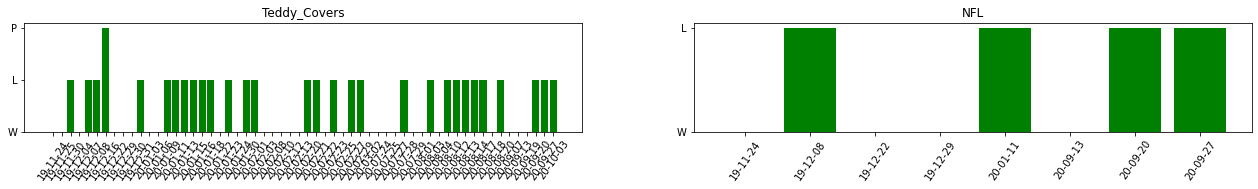

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
630,20-09-13,NFL,Miami at New England,Teddy_Covers,-6 NE,W,U,NE
647,20-09-19,NCAAF,Miami at Louisville,Teddy_Covers,MIA,W,O,MIA
650,20-09-20,NFL,San Francisco at N.Y. Jets,Teddy_Covers,7 NYJ,L,O,SF
671,20-09-27,NFL,Dallas at Seattle,Teddy_Covers,5 DAL,L,O,SEA
686,20-10-03,NCAAF,Louisiana State at Vanderbilt,Teddy_Covers,21 VAN,L,U,LSU


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
125,19-12-29,NFL,Philadelphia at N.Y. Giants,Teddy_Covers,Over 45,W,O,PHI
183,20-01-11,NFL,Minnesota at San Francisco,Teddy_Covers,7 MIN,L,U,SF
630,20-09-13,NFL,Miami at New England,Teddy_Covers,-6 NE,W,U,NE
650,20-09-20,NFL,San Francisco at N.Y. Jets,Teddy_Covers,7 NYJ,L,O,SF
671,20-09-27,NFL,Dallas at Seattle,Teddy_Covers,5 DAL,L,O,SEA



 Will_Rogers 


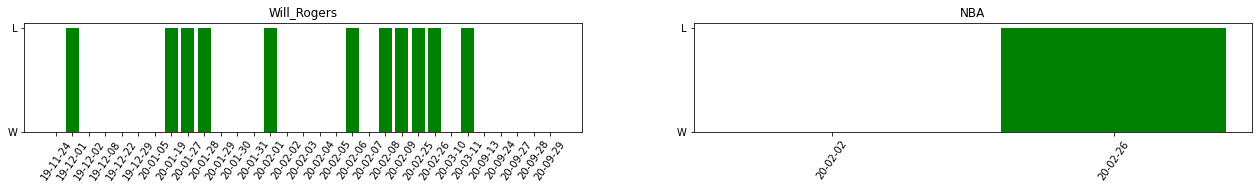

,Date,League,Matchup,Capper,Pick,WL,Total,Winner
632,20-09-13,NFL,Tampa Bay at New Orleans,Will_Rogers,-4 NO,W,O,NO
657,20-09-24,MLB,Chi. White Sox at Cleveland,Will_Rogers,CLE,W,O,CLE
673,20-09-27,NFL,Tampa Bay at Denver,Will_Rogers,-6 TB,W,U,TB
675,20-09-28,NHL,Tampa Bay at Dallas,Will_Rogers,TB,W,U,TB
677,20-09-29,MLB,Houston at Minnesota,Will_Rogers,Under 7.5,W,U,HOU


,Date,League,Matchup,Capper,Pick,WL,Total,Winner
294,20-02-02,NBA,Chicago at Toronto,Will_Rogers,-10.5 TOR,W,O,TOR
417,20-02-26,NBA,Memphis at Houston,Will_Rogers,10 MEM,L,O,HOU


In [ ]:
#ПРОГНОЗЫ НА СЕГОДНЯ И СТАТИСТИКА КАППЕРОВ
FP=pd.read_csv(path+'FP_{}.csv'.format(dat))
FP.drop(['WL'],inplace=True,axis=1)
today_picks=df_cappers.merge(FP,how='left',on='Capper')
today_picks.dropna(inplace=True)
display(today_picks)
for ind in today_picks.index:
  cap=today_picks.loc[ind,'Capper']
  liga=today_picks.loc[ind,'League']
  tmp1=all_fp.query(f"Capper=='{cap}'")
  tmp2=all_fp.query(f"Capper=='{cap}' & League=='{liga}'")
  print()
  print("\033[105m",cap,"\033[0m")
  fig,axs=plt.subplots(1,2,figsize=(22,2))
  axs[0].bar(tmp1['Date'],tmp1['WL'],color='g')
  axs[0].set_title(cap)
  axs[0].set_xticklabels(tmp1['Date'],rotation=55)
  axs[1].bar(tmp2['Date'],tmp2['WL'],color='g')
  axs[1].set_title(liga)
  axs[1].set_xticklabels(tmp2['Date'],rotation=55)
  plt.show()
  display(tmp1.tail(),tmp2.tail())

In [ ]:
FP

,League,Matchup,Capper,Pick
0,MLB,San Diego at LA Dodgers,Mike Lundin,SD
1,NBA,Dallas at Phoenix,Teddy Covers,9 DAL
2,NBA,San Antonio at Utah,AAA Sports,8 UTA
3,NBA,Portland at Brooklyn,Lee Sterling,9 BK
4,NFL,Houston at Kansas City,Marc Lawrence,Under 55
5,NFL,Tampa Bay at New Orleans,Will Rogers,-4 NO
6,NFL,Las Vegas at Carolina,Ben Burns,0 LV
7,NHL,Chicago at Vegas,Dan Kaiser,Under 6.5
8,NHL,Chicago at Vegas,Scott Rickenbach,Over 6
9,NHL,Carolina at Boston,Larry Ness,BOS


In [ ]:
#xxx=all_fp.groupby(by=['League','Capper'])['WL'].value_counts()
display(xxx['NBA'].index)

In [ ]:
def del_sk(vval):
  if vval[-5]=='(':
    return vval[:-6]
  else:
    return vval[:-7]
def WinLose(row):
  ret='-'
  if str(row['Date'])!='nan':
    if 'Over' in row['Pick']:
      if row['Total']=='O':
        ret='W'
      else:
        ret='L'
    elif 'Under' in row['Pick']:
      if row['Total']=='U':
        ret='W'
      else:
        ret='L'
    elif str(row['Winner']) in str(row['Pick']):
      ret='W'
    else:
      ret='L'
  return ret

d=dt.now()
d-=td(days=1)
date_res=d.strftime('%y-%m-%d')
date_picks=d.strftime('%y-%m-%d')
picks=pd.read_csv(path+'FP_{}.csv'.format(date_picks))
display(picks)
results=pd.read_csv(path_res+'{}.csv'.format(date_res))
picks['Matchup']=picks.Matchup.apply(lambda x: x.replace(' at. ',' at '))
#picks['Pick']=picks.Pick.apply(del_sk)
picks=picks.merge(results,how='left',on=['League','Matchup']).drop(labels=['Teams'],axis=1)
col_Date=picks['Date']
picks.drop(labels=['Date'],inplace=True,axis=1)
picks.insert(0,'Date',col_Date)
wl=picks.apply(WinLose,axis=1)
picks['WL']=wl
#picks.dropna(inplace=True)
display(picks)

In [ ]:
#Корректировка имен капперов
for f in range(24,31):
  fname='FP_20-07-'+str(f)+'.csv'
  #fname='FreePicks_All.csv'
  c=pd.read_csv(path+fname)
  cap=c['Capper'].to_list()
  cap=list(map(lambda x: x.replace('_',' ').title().replace(' ','_').replace('Aaa','AAA').replace('Mcmordie','McMordie'),cap))
  c['Capper']=cap
  c.to_csv(path+fname,index=False)


In [ ]:
#ПЕРЕИМЕНОВАНИЕ ФАЙЛОВ
files=os.listdir(path)
#display(sorted(files))
#for f in files:
  #f_new=f.replace('_11 ','19-11-').replace('_12 ','19-12-').replace('_01 ','20-01-').replace('_02 ','20-02-').replace('FreePicks','FP_')
  #print(f_new)
  #os.rename(path+f,path+f_new)

In [ ]:
d=dt.now()
#d=dt.strptime('12.09','%m.%d')
d-=td(days=1)
date_res=d.strftime('%b %d')
date_picks=d.strftime('%m %d')
picks=pd.read_csv(path+'FreePicks_{}.csv'.format(date_picks))
results=pd.read_csv(path_res+'{}.csv'.format(date_res))
display(picks,results)

In [ ]:
#ПЕРЕФОРМАТИРОВАНИЕ ФАЙЛОВ 1
def correct(row):
  row['Matchup']=row['Matchup'].replace(' at. ',' at ')
  pick=row['Pick']
  p=pick.find('(')
  if p>-1:
    row['Pick']=pick[:p-1]
  return row

files=os.listdir(path)
for f in files[:17]:
  df=pd.read_csv(path+f)
  df=df.apply(correct,axis=1)
  df.to_csv(path+f,index=False)

In [ ]:
#ПЕРЕФОРМАТИРОВАНИЕ ФАЙЛОВ 2
def correct(row):
  row['Matchup']=row['Team1']+' at '+row['Team2']
  pick=row['Pick']
  p=pick.find('(')
  if p>-1:
    row['Pick']=pick[:p-1]
  return row

files=os.listdir(path)
for f in files[:17]:
  df=pd.read_csv(path+f)
  df.insert(1,'Matchup','')
  df=df.apply(correct,axis=1)
  df.drop(labels=['Team1','Team2'],axis=1,inplace=True)
  df.to_csv(path+f,index=False)

In [ ]:
#OLD VERSION
r=requests.get('https://experts.covers.com/freepicks',headers=headers)
soup=BeautifulSoup(r.text,'html.parser')
picks=soup.find_all(class_='cmg_brick_content covers-coversFreePicks-colums freePickRecord')
cols=['League','Matchup','Capper','Pick','WL']
dat=(dt.now()).strftime('%y-%m-%d')
FP=pd.DataFrame(columns=[x for x in range(5)])
for el in range(len(picks)):
  team2=picks[el].find(class_='cmg_l_col cmg_l_span_2 covers-CoversFreePick-featured-logos').find('img').get('data-participant')
  team1=picks[el].find(class_='cmg_l_col cmg_l_span_2 covers-CoversFreePick-featured-logos2').find('img').get('data-participant')
  capper=picks[el].find(class_='cmg_l_col cmg_l_span_2 covers-CoversFreePick-featuredTime covers-CoversFreePick-handicapperMargin').find('a').get('href').split('/')[-1]
  capper=capper.replace('_',' ').title().replace(' ','_').replace('Aaa','AAA')
  sport=picks[el].find(class_='cmg_l_col cmg_l_span_3 covers-CoversFreePick-handicapperMargin').find('strong').get_text()
  pick=picks[el].find(class_='covers-CoversFreePick-offeredAt--detail').get_text().split(' @ ')[1]
  x=pick.find('(')
  pick=pick[:x-1]
  teams=team2+' at '+team1
  temp=(pd.DataFrame(pd.Series([sport,teams,capper,pick,''])).T)
  FP=FP.append(temp)
FP.columns=cols
FP=FP.reset_index(drop=True)
FP=FP.sort_values(['League'])
display(FP[FP['League']=='MLB'],FP)
FP.to_csv(path+'FP_{}.csv'.format(dat),index=False)